<a href="https://colab.research.google.com/github/LorenzoPozzi97/deprEUession/blob/main/deprEUssion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import sqlite3, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from itertools import combinations



# Utils

In [8]:
class Database:
  def __init__(self, df):
    self.df = df
    self.length = len(df)

  def Nan_plt(self, size=(10,7)):
    '''
      Returns:
        Plot the number of NaN values for each column against the total number 
        of samples (might consider to analyze simple groups though)
    '''
    NAs=[]
    rest=[]
    for col in self.df:
      NAs.append(self.df[col].isna().sum())
      rest.append(self.length-self.df[col].isna().sum())

    x = np.arange(len(NAs))
    plt.figure(figsize=size)
    plt.bar(x, NAs, color='r')
    plt.bar(x, rest, bottom=NAs, color='skyblue')
    plt.xticks(x, df.columns, rotation='vertical')
    plt.ylabel('NaN')

  def Nan_column_plt(self, column, value, size=(10,7)):
    '''
      Args:
        column {str}: column containing the value
        value {str}: filter the indicated column to a specifc category
      Returns:
        Plot the number of NaN values for indicated column against the total number 
        of samples 
    '''
    NAs=[]
    rest=[]
    snippet_df = self.df[self.df[column]==value]
    for col in snippet_df:
      NAs.append(snippet_df[col].isna().sum())
      rest.append(self.length-snippet_df[col].isna().sum())

    x = np.arange(len(NAs))
    plt.figure(figsize=size)
    plt.bar(x, NAs, color='r')
    plt.bar(x, rest, bottom=NAs, color='skyblue')
    plt.xticks(x, df.columns, rotation='vertical')
    plt.ylabel('NaN')

  def multi_Nan_column_plt(self, groups, size=(15, 12), hspace=0.5):
    '''
      Args:
        groups {str}: column containing the groups/classes
      Returns:
        Plot the number of NaN values for all columns against the total number 
        of samples 
    '''
    # define subplot grid
    n = math.ceil(np.sqrt(len(set(self.df[groups]))))
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=size)
    plt.subplots_adjust(hspace=hspace)
    i=0
    j=0
    z=0
    for value in set(self.df[groups]):
      z+=1
      NAs=[]
      rest=[]
      snippet_df = self.df[self.df[groups]==value]
      for col in snippet_df:
        NAs.append(snippet_df[col].isna().sum())
        rest.append(self.length-snippet_df[col].isna().sum())

      x = np.arange(len(NAs))
      axs[j, i].bar(x, NAs, color='r')
      axs[j, i].bar(x, rest, bottom=NAs, color='skyblue')
      axs[j, i].set_xticks(x)
      axs[j, i].set_xticklabels(df.columns, rotation=90)
      axs[j, i].set_title(value)
      i+=1
      if i == n:
        i=0
        j+=1
      if z == len(set(self.df[groups])):
        break
  def oneway_anova(self, col, groups):
    model = ols('{} ~ C({})'.format(col, groups), data=self.df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(aov_table)
    print(f'Normality of Residuals (if <0.05 anova results are not reliable!): {stats.shapiro(model.resid)}')
    print('NB: check also homogeneity of variance')

  def homogeneity_of_variance(self, category, groups, cols):
    """
      Args:
        category {str}: name of the column containing the groups
        groups {list[str]}: list having the specific groups
        cols {list[str]}: list havnig the columns to be analyzed

      Returns:
        The function print the varinace of each group in the analyzed columns, 
        and returns the confidence of Levene test. If p-value <0.05 the variance
        is non homogeneous (consider using a non-parametric test if sample sizes
        are significantly different)
    """
    for col in cols:
      print(f'### {col} ###')
      vars = [np.var(self.df[self.df[category]==group][col]) for group in groups]
      print('Groups variance:\n'+('\t{}\n'*len(vars)).format(*vars))
      t = stats.levene(*[self.df[self.df[category]==group][col] for group in groups])
      print(f'Levene test\n\tNull hypothesis: all input samples have similar variances.\n\t{t}')


  def multi_Ttest(self, category, groups, cols, equal_var=True, plot_boxplot=False):
    """
      Args:
        category {str}: name of the column containing the groups
        groups {list[str]}: list having the specific groups
        cols {list[str]}: list havnig the columns to be analyzed
        equal_var {bool}: if the samples have equal bar or not
        plot_boxplot {bool}: if output boxplot of means or not

      Returns:
        The function print the result of a T-test (or Welch T-test in case of 
        non-homogeneous variance) and a graph plotting the mean of each groups. 
    """

    for col in cols:
      if plot_boxplot:
        fig = plt.figure(figsize= (10, 10))
        ax = fig.add_subplot(111)
        ax.set_title(col, fontsize= 20)
        ax.set
        data = [self.df[self.df[category]==group][col] for group in groups]

        ax.boxplot(data,
                  labels = groups,
                  showmeans= True)

        plt.xlabel(category)
        plt.ylabel("Dependent Variable")

        plt.show()
      for pair in combinations(groups, 2):
        t, p = stats.ttest_ind(self.df[self.df[category]==pair[0]][col],
                            self.df[self.df[category]==pair[1]][col], 
                            equal_var = equal_var)
        print(f"T-test between ({pair[0]}) and ({pair[1]}):\n\tT-statistic = {t}\n\tP-value = {p}")
      print('\n')
    

In [9]:
acr_to_name = {
    'BE':'Belgium', 
    'EL':'Greece',
    'LT':'Lithuania',
    'PT':'Portugal',
    'BG':'Bulgaria',
    'ES':'Spain',
    'LU':'Luxembourg',
    'RO':'Romania',
    'CZ':'Czechia',
    'FR':'France', 
    'HU':'Hungary',
    'SI':'Slovenia',
    'DK':'Denmark',
    'HR':'Croatia',
    'MT':'Malta',
    'SK':'Slovakia',
    'DE':'Germany',
    'IT':'Italy',
    'NL':'Netherlands',
    'FI':'Finland',
    'EE':'Estonia',
    'CY':'Cyprus',
    'AT':'Austria',
    'SE':'Sweden',
    'IE':'Ireland',
    'LV':'Latvia',
    'PL':'Poland',
    'EU28':'Enlargement of the European Union', 
    'IS':'Iceland',
    'NO':'Norway',
    'LI':'Liechtenstein',
    'CH':'Switzerland', 
    'ME':'Montenegro',
    'MK':'North Macedonia', 
    'AL':'Albania',
    'RS':'Serbia',
    'TR':'Türkiye',
    'EU27_2020':'European Union after UK exit',
    'EA19':'Euro Area 2019',
    'UK':'United Kingdom', 
    'EU15': 'European Union 2015'
}

# Preprocessing

In [10]:
df = pd.read_csv('/content/hlth_ehis_mh1e.tsv', sep=',|\t')

In [11]:
# rename and remove spaces in column names
df=df.rename(columns = {'geo\\time':'geo'})
for i, col in enumerate(df):
  if col[0].isdigit():
    df=df.rename(columns={col: 'y_'+col.strip()})
  else:
    df=df.rename(columns={col: col.strip()})

# convert acronyms of countries
df=df.replace({"geo": acr_to_name})

## Transform some Variables

In [12]:
# covert str into float
for col in df:
  if col in ['sex', 'age','unit', 'isced11', 'geo', 'hlth_pb']:
    continue
  df[col] = df[col].map(lambda x: re.findall(r'\d+\.\d+', x)[0] if len(re.findall(r'\d+\.\d+', x))>0 else None)
  df[col] = pd.to_numeric(df[col])

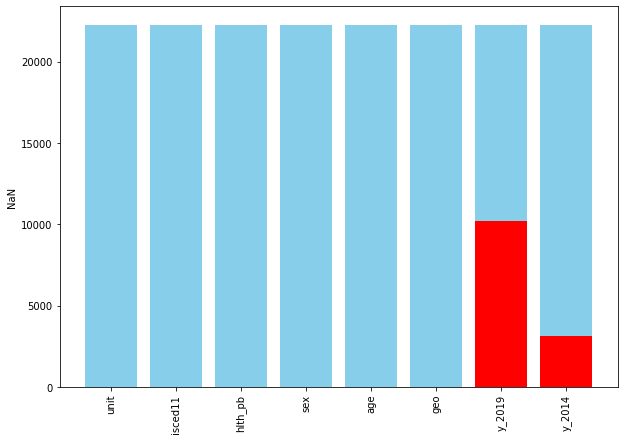

In [14]:
database = Database(df)
database.Nan_plt()

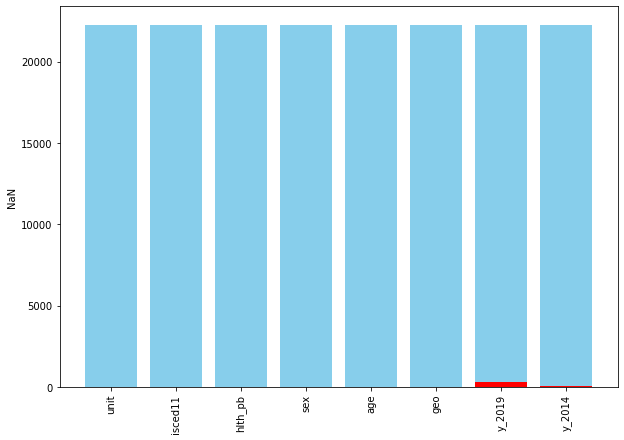

In [15]:
database.Nan_column_plt(column='geo', value='Italy')

           y_2019      y_2014
count  396.000000  651.000000
mean     2.661616    2.231029
std      2.127289    2.025838
min      0.300000    0.100000
25%      1.300000    1.100000
50%      2.050000    1.700000
75%      3.400000    2.600000
max     15.300000   16.600000


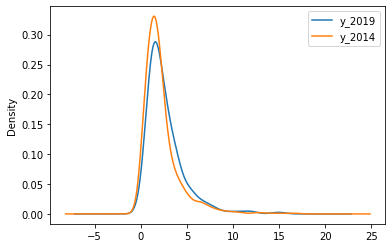

In [16]:
italy = df[df['geo']=='Italy']
df1 = italy.groupby(['isced11']).mean()
print(italy.describe())
italy.plot.kde()

In [17]:
for col in df1:
  for edu, (index, row) in zip(['ED0-2', 'ED3_4', 'ED5-8', 'TOTAL'], df1.iterrows()):
    avg = row[col]
    italy.loc[(italy[col].isnull()) & (italy['isced11']==edu), col] = avg

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


           y_2019      y_2014
count  684.000000  684.000000
mean     2.661616    2.209758
std      1.645100    1.983563
min      0.300000    0.100000
25%      1.800000    1.100000
50%      2.402020    1.600000
75%      3.277778    2.600000
max     15.300000   16.600000


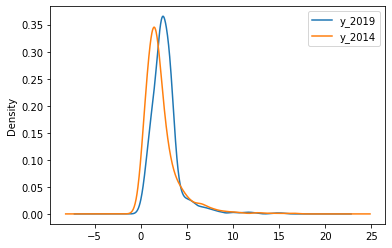

In [18]:
print(italy.describe())
italy.plot.kde()

# ANOVA

In [19]:
model = ols('y_2014 ~ C(isced11)', data=italy[italy['isced11']!='TOTAL']).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(isced11),250.557576,2.0,40.673718,4.078511e-17
Residual,1570.846835,510.0,NaN,NaN


## Normality of Residuals

The test is non-significant, W= 0.7931, p= 5.0397e-25, which indicates that the residuals are NOT normally distributed.

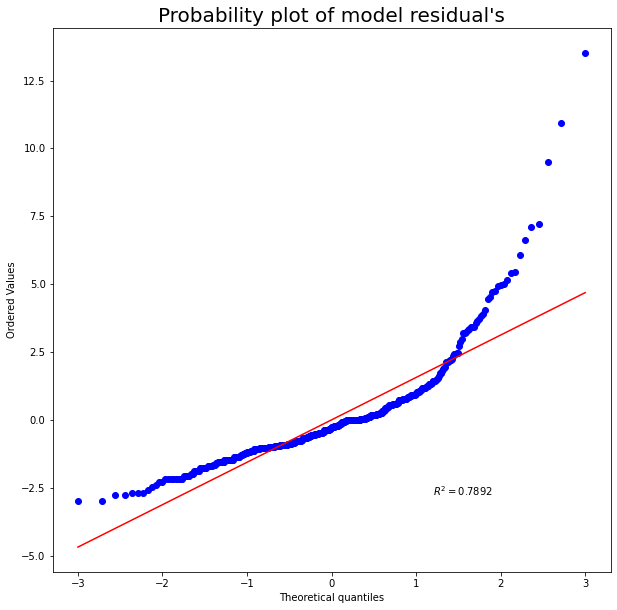

In [20]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

## Homogeneity of Variance

In [21]:
print(np.var(italy[italy['isced11']=='ED0-2']['y_2014']), 
      np.var(italy[italy['isced11']=='ED3_4']['y_2014']), 
      np.var(italy[italy['isced11']=='ED5-8']['y_2014']))

stats.levene(italy[italy['isced11']=='ED0-2']['y_2014'],
             italy[italy['isced11']=='ED3_4']['y_2014'],
             italy[italy['isced11']=='ED5-8']['y_2014'])


6.288221158958001 1.7824429911069586 1.1155746509129971


LeveneResult(statistic=19.77293965727833, pvalue=5.362733251163071e-09)

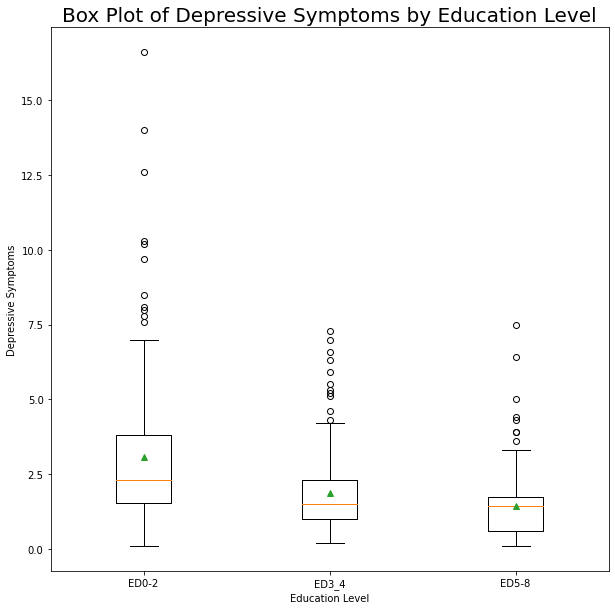

In [22]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Depressive Symptoms by Education Level", fontsize= 20)
ax.set

data = [italy[italy['isced11']=='ED0-2']['y_2014'],
        italy[italy['isced11']=='ED3_4']['y_2014'],
        italy[italy['isced11']=='ED5-8']['y_2014']]

ax.boxplot(data,
           labels= ['ED0-2', 'ED3_4', 'ED5-8'],
           showmeans= True)

plt.xlabel("Education Level")
plt.ylabel("Depressive Symptoms")

plt.show()


#Welch ANOVA

In [23]:
#Check whether there is equal variance between scores of those three strategies.
#We can use Bartlett’s test to see if the variances in each group are equal.

stats.bartlett(italy[italy['isced11']=='ED0-2']['y_2014'],
               italy[italy['isced11']=='ED3_4']['y_2014'],
               italy[italy['isced11']=='ED5-8']['y_2014'])

#The p-value (2.47e-31) from Bartlett’s test is less than α = .05, which means we 
#can reject the null hypothesis that each group has the same variance. Thus, 
#the assumption of equal variances is violated and we can proceed to perform 
#Welch’s ANOVA.

BartlettResult(statistic=140.9440373487659, pvalue=2.479654431752146e-31)

In [24]:
pg.welch_anova(dv='y_2014', between='isced11', data=italy[italy['isced11']!='TOTAL'])

#The overall p-value (1.74e-13) from the ANOVA table is less than α = .05, 
#which means we can reject the null hypothesis that the exam scores are equal 
#between the three studying techniques.

,Source,ddof1,ddof2,F,p-unc,np2
0,isced11,2,315.327172,32.288904,1.749336e-13,0.137563


## Normal Distribution

In [25]:
x = italy[(italy['hlth_pb']=='DPR')&(italy['isced11']=='ED5-8')]['y_2014']
#x = italy[(italy['hlth_pb']=='DPR')&(italy['isced11']!='ED5-8')&(italy['isced11']!='TOTAL')]['y_2014']

k2, p = stats.normaltest(x)
print("p = {:g}".format(p))

p = 2.14284e-12


# Welch T-test

In [26]:
import statsmodels.stats.multicomp as mc

print(stats.ttest_ind(italy[italy['isced11']=='ED0-2']['y_2014'],
                      italy[italy['isced11']=='ED3_4']['y_2014'], 
                      equal_var = False))


Ttest_indResult(statistic=5.587150112799057, pvalue=5.8309771624178904e-08)


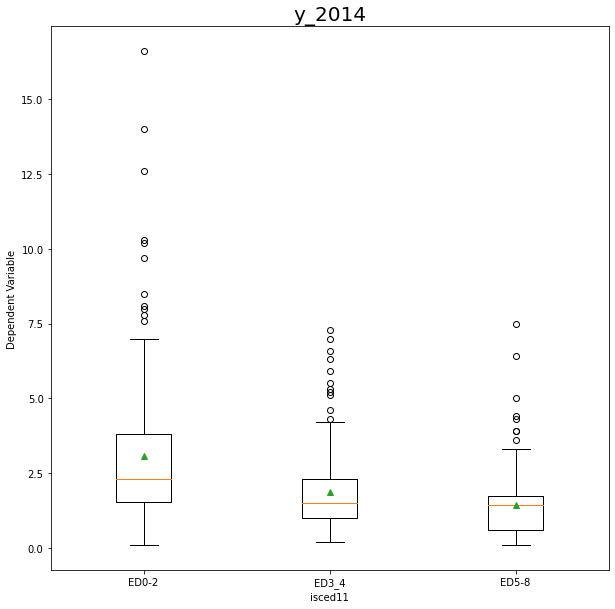

T-test between (ED0-2) and (ED3_4):
	T-statistic = 5.587150112799057
	P-value = 4.736495746019682e-08
T-test between (ED0-2) and (ED5-8):
	T-statistic = 7.911155577381301
	P-value = 3.620741740298898e-14
T-test between (ED3_4) and (ED5-8):
	T-statistic = 3.3211032688066355
	P-value = 0.000994009422934332




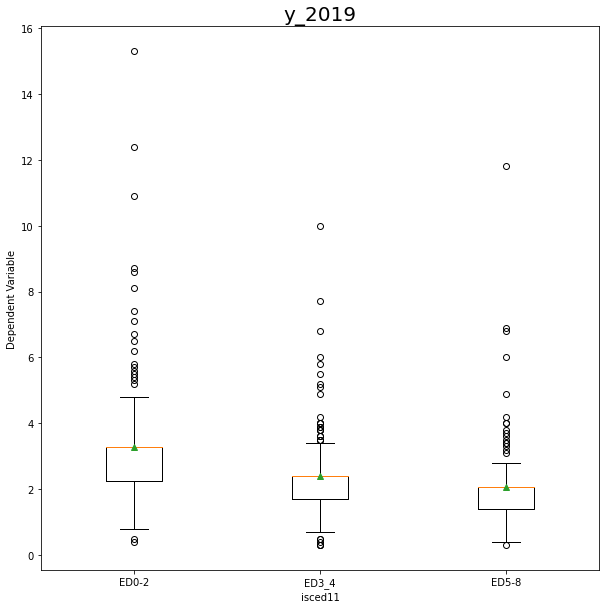

T-test between (ED0-2) and (ED3_4):
	T-statistic = 4.9310896313963735
	P-value = 1.2812296953040164e-06
T-test between (ED0-2) and (ED5-8):
	T-statistic = 6.853744983365346
	P-value = 3.393036840074496e-11
T-test between (ED3_4) and (ED5-8):
	T-statistic = 2.4401897991543686
	P-value = 0.015189763147421691




In [27]:
cols = ['y_2014', 'y_2019']
groups = ['ED0-2', 'ED3_4', 'ED5-8']
category = 'isced11'
def multi_Ttest(df, category, groups, cols, equal_var=True):
  for col in cols:
    fig = plt.figure(figsize= (10, 10))
    ax = fig.add_subplot(111)
    ax.set_title(col, fontsize= 20)
    ax.set
    data = [df[df[category]==group][col] for group in groups]

    ax.boxplot(data,
              labels = groups,
              showmeans= True)

    plt.xlabel(category)
    plt.ylabel("Dependent Variable")

    plt.show()
    for pair in combinations(groups, 2):
      t, p = stats.ttest_ind(df[df[category]==pair[0]][col],
                          df[df[category]==pair[1]][col], 
                          equal_var = equal_var)
      print(f"T-test between ({pair[0]}) and ({pair[1]}):\n\tT-statistic = {t}\n\tP-value = {p}")
    print('\n')
multi_Ttest(italy, category, groups, cols, equal_var=True)

In [28]:
it = Database(italy)
it.multi_Ttest(category, groups, cols, equal_var=True)

T-test between (ED0-2) and (ED3_4):
	T-statistic = 5.587150112799057
	P-value = 4.736495746019682e-08
T-test between (ED0-2) and (ED5-8):
	T-statistic = 7.911155577381301
	P-value = 3.620741740298898e-14
T-test between (ED3_4) and (ED5-8):
	T-statistic = 3.3211032688066355
	P-value = 0.000994009422934332


T-test between (ED0-2) and (ED3_4):
	T-statistic = 4.9310896313963735
	P-value = 1.2812296953040164e-06
T-test between (ED0-2) and (ED5-8):
	T-statistic = 6.853744983365346
	P-value = 3.393036840074496e-11
T-test between (ED3_4) and (ED5-8):
	T-statistic = 2.4401897991543686
	P-value = 0.015189763147421691




In [29]:
it.homogeneity_of_variance(category, groups, cols)

### y_2014 ###
Groups variance:
	6.288221158958001
	1.7824429911069586
	1.1155746509129971

Levene test
	Null hypothesis: all input samples have similar variances.
	LeveneResult(statistic=19.77293965727833, pvalue=5.362733251163071e-09)
### y_2019 ###
Groups variance:
	3.7659129304743337
	1.5961379880678128
	1.480653316793668

Levene test
	Null hypothesis: all input samples have similar variances.
	LeveneResult(statistic=5.8474926820633435, pvalue=0.0030842249031396048)
